# Import Library

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from os import getcwd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cwd = getcwd() + "/drive/Shareddrives/CAPSTONE_ML/"
print(cwd)

/content/drive/Shareddrives/CAPSTONE_ML/


In [3]:
df_all = pd.read_excel(cwd + "df_all_new.xlsx")
df_all.head()

,Page_URL,Shop_name,Rating,Reviews,Kategori,Address,Phone_Number,Opening_Hours,Range_Harga,Latitude,Longitude,Eco_Friendly,Categorize_Weather
0,https://www.google.com/maps/place/Wedang+Uwuh+...,Wedang Uwuh Solo - Pak Aden,4.6,5,Wedang Uwuh,"Mutihan rt 04 rw 1, Surakarta, Sondakan, Kec. ...",082324006000,"{'Senin': ['08.00–20.00'], 'Selasa': ['08.00–2...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
1,https://www.google.com/maps/place/Rajanya+JAHE...,Rajanya JAHE REMPAH wedhang uwuh Sumber,4.6,32,Wedang Uwuh,"Jl. Letjen Suprapto No.76c, Sumber, Kec. Banja...",085641727445,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.566731,110.716919,0,Dingin
2,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh jelantik solo,5.0,1,Wedang Uwuh,"Jl. Sungai Musi No.1, Sangkrah, Kec. Ps. Kliwo...",081229070267,"{'Senin': ['Buka 24 jam'], 'Selasa': ['Buka 24...",Rp 1–25 rb,-7.576765,110.768229,0,Dingin
3,https://www.google.com/maps/place/Wedang+uwuh+...,Wedang uwuh mbok tuo,4.9,14,Wedang Uwuh,"Jl. Kutai Tim. 5B, RT.05/RW.08, Sumber, Kec. B...",081578614885,"{'Senin': ['07.00–19.00'], 'Selasa': ['07.00–1...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin
4,https://www.google.com/maps/place/wedang+uwuh+...,wedang uwuh sya,4.7,3,Wedang Uwuh,"Jl. Reksoniten No.20, Gajahan, Kec. Ps. Kliwon...",089608149211,"{'Minggu': ['Buka 24 jam'], 'Senin': ['Buka 24...",Rp 1–25 rb,-7.547894,110.730811,0,Dingin


# Fungsi untuk menghitung jarak menggunakan formula haversine

In [4]:
def calculate_haversine(lat1, lon1, lat2, lon2):
    earth_radius = 6371
    delta_lat = np.radians(lat2 - lat1)
    delta_lon = np.radians(lon2 - lon1)
    a = np.sin(delta_lat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return earth_radius * c

# Inisialisasi lokasi pengguna

In [5]:
# Lokasi pengguna
current_lat = -7.579666911699041
current_lon = 110.78387592210068

# Menghitung jarak tiap lokasi berdasarkan input latitude dan longitude pengguna

In [6]:
# Hitungan jarak untuk setiap lokasi dalam dataset
df_all['computed_distance'] = df_all.apply(
    lambda row: calculate_haversine(current_lat, current_lon, row['Latitude'], row['Longitude']), axis=1
)

In [7]:
df_all[['Shop_name','computed_distance', 'Latitude', 'Longitude', 'Rating', 'Reviews']].sort_values(by='computed_distance').head()

,Shop_name,computed_distance,Latitude,Longitude,Rating,Reviews
312,Nasi Liwet Yu Djamboel,0.187293,-7.580959,110.784967,4.5,16
313,SEGO LIWET BU KEKEP,0.187293,-7.580959,110.784967,4.5,21
311,Nasi Liwet Bu Yati,0.187293,-7.580959,110.784967,4.6,170
310,Nasi Liwet & Cabuk Rambak Bu Parmi,0.187293,-7.580959,110.784967,4.6,1374
307,Nasi Liwet Yu Sani Gemblegan,0.330882,-7.582277,110.785317,4.5,2143


# Persiapan data untuk model


In [8]:
# Weighted Rating
C = df_all['Rating'].mean()
M = df_all['Reviews'].quantile(0.5)
df_all['weighted_rating'] = ((df_all['Reviews'] / (df_all['Reviews'] + M)) * df_all['Rating']) + ((M / (df_all['Reviews'] + M)) * C)

# Data fitur dan target
features = df_all[['computed_distance', 'weighted_rating']]
target = df_all['computed_distance']  # Target jarak untuk pemeringkatan

# Normalisasi data fitur
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

# Split training dan testing
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target.to_numpy(), test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)  # (jumlah_data, jumlah_fitur)
print("y_train shape:", y_train.shape)  # (jumlah_data,)

# Dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Opsional: shuffling dan batching
dataset = dataset.shuffle(buffer_size=100).batch(32)

X_train shape: (485, 2)
y_train shape: (485,)


# Membuat arsitektur model menggunakan adam optimizer dan loss Mean Squared Error dan menambahkan metrics mae (pengennya accuracy)

In [9]:
# Arsitektur model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
# Compile model
model1.compile(optimizer='adam', loss="mse", metrics=['mae'])  # Loss: Mean Squared Error, Metrics: Mean Absolute Error

# Memulai proses training dan menyimpannya kedalam variable history

In [10]:
# save_best = tf.keras.callbacks.ModelCheckpoint("Model.keras", verbose=1, monitor='val_accuracy', save_best_only=True)

In [11]:
# history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[save_best])
history = model1.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 74.0630 - mae: 5.7318 - val_loss: 12.5674 - val_mae: 2.4270
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 41.2123 - mae: 3.5876 - val_loss: 12.2600 - val_mae: 3.1700
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.6181 - mae: 3.3004 - val_loss: 7.2447 - val_mae: 2.2780
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.1685 - mae: 2.8484 - val_loss: 6.7446 - val_mae: 2.3317
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.7500 - mae: 2.6463 - val_loss: 3.5401 - val_mae: 1.5464
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.9408 - mae: 1.8100 - val_loss: 1.5780 - val_mae: 1.0594
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6970 - mae: 1.1232 - val_loss: 0.2689 - val_mae: 0.3970
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5306 - mae: 0.3646 - val_loss: 0.0932 - val_mae: 0.2346
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

In [18]:
model1.save(cwd + '/model_ml.keras')
#model1.save(cwd + '/model_ml.h5')

# Menguji performa model setelah dilakukan training

In [13]:
test_loss, test_mae = model1.evaluate(X_test, y_test, verbose=0)
print(f"Mean Absolute Error pada data uji: {test_mae}")

Mean Absolute Error pada data uji: 0.002882282016798854


In [14]:
# Membuat prediksi pada data baru
df_all['predicted_distance'] = model1.predict(features_normalized)

# Mendapatkan rekomendasi berdasarkan jarak terprediksi
top_recommendations = df_all.sort_values(by='predicted_distance', ascending=True).head(20)

# Menampilkan rekomendasi
print("Rekomendasi teratas berdasarkan prediksi jarak:")
print(top_recommendations[['Shop_name', 'Latitude', 'Longitude', 'Rating', 'Reviews', 'Categorize_Weather', 'computed_distance','predicted_distance']])


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Rekomendasi teratas berdasarkan prediksi jarak:
                                             Shop_name  Latitude   Longitude  \
313                                SEGO LIWET BU KEKEP -7.580959  110.784967   
312                             Nasi Liwet Yu Djamboel -7.580959  110.784967   
311                                 Nasi Liwet Bu Yati -7.580959  110.784967   
310                 Nasi Liwet & Cabuk Rambak Bu Parmi -7.580959  110.784967   
307                       Nasi Liwet Yu Sani Gemblegan -7.582277  110.785317   
308                     Nasi Liwet Bu Sarmi, Lojiwetan -7.582277  110.785317   
219                          Hokage "pukis dan serabi" -7.579439  110.780743   
145  Spesial Soto Boyolali (SSB) Hj Hesti Widodo, S... -7.582309  110.781665   
177                       Soto Ayam Kampung Pak Timbul -7.575004  110.783061   
319                  Nasi Liwet & Cabuk Rambak Bu Hadi -7.574647  110.787087   
318                             N

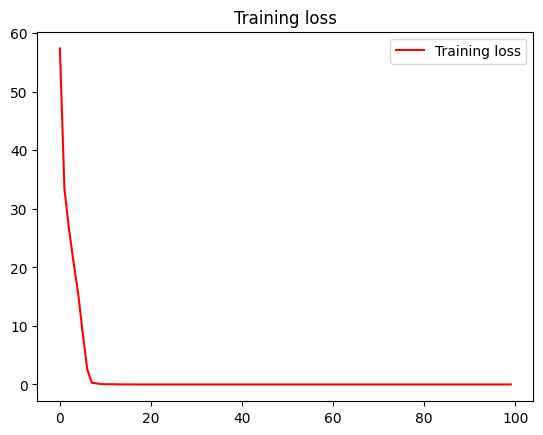

In [15]:
# Plot training loss untuk tiap each
import matplotlib.pyplot as plt

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

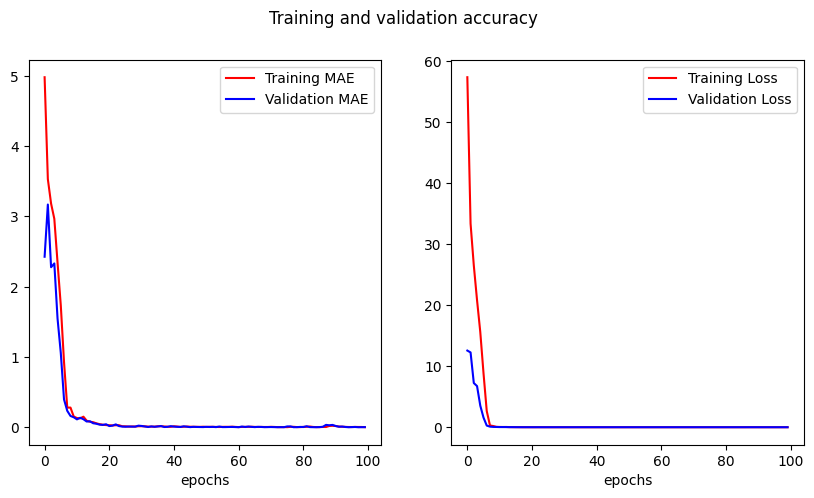

In [16]:
# Akurasi training dan validasi
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mae))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(mae, val_mae), (loss, val_loss)], ["MAE", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [17]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras
